https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook

https://towardsdatascience.com/detecting-credit-card-fraud-using-machine-learning-a3d83423d3b8

https://www.kaggle.com/abdul002/credit-card-fraud-detection

https://www.kaggle.com/renjithmadhavan/credit-card-fraud-detection-using-python

https://www.sciencedirect.com/science/article/pii/S1877050918309347

https://engmrk.com/module-19-credit-card-fraud-detection/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels

https://en.wikipedia.org/wiki/Data_analysis_techniques_for_fraud_detection

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets



In [71]:
from datetime import datetime
from typing import List, Dict
import re
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
#from sklearn.utils.fixes import signature
from sklearn.externals.funcsigs import signature
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_recall_curve, \
roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, precision_score, make_scorer, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, RobustScaler



ModuleNotFoundError: No module named 'sklearn.externals.funcsigs'

In [6]:
# Import pandas and read csv
df_original = pd.read_csv("data/creditcard.csv")


## Description of the data

In [7]:
print(df_original.info(), '\n')
print('shape of the dataframe', df_original.shape, '\n')
print('column names', df_original.columns, '\n')

# Count the occurrences of fraud and no fraud and print them
occ = df_original['Class'].value_counts()
print('occurrences \n', occ, '\n')

# Print the ratio of fraud cases
print('ratio of the non fraud and fraud \n', occ / occ.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [8]:
normal_transaction =  df_original[df_original.Class == 0]
abnormal_transaction =  df_original[df_original.Class == 1]

In [9]:
print('normal transaction')
print(normal_transaction.Amount.describe())
print('\n')
print('abnormal transaction')
print(abnormal_transaction.Amount.describe())

normal transaction
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


abnormal transaction
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [10]:
# abnormal transaction has higher average amount

In [59]:
# check missing values
df_original.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# Visualization

Text(0.5, 1.0, 'Abnormal transction')

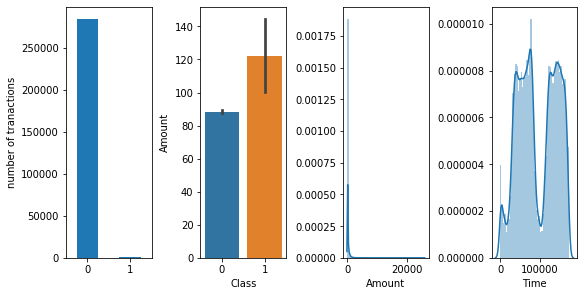

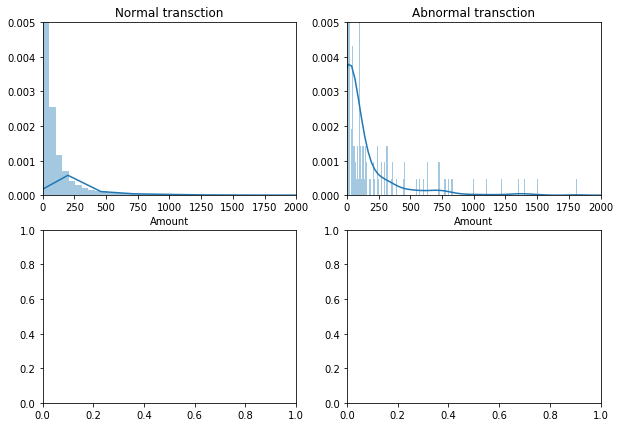

In [12]:
# (1) overview of the data
fig, axes1 = plt.subplots(1, 4, figsize=(8, 4), constrained_layout=True)
    # count numbers
df_original.Class.value_counts().plot.bar(ax=axes1[0], rot=0)
axes1[0].set_ylabel('number of tranactions')
    # amount
sns.barplot(ax=axes1[1], data=df_original, x='Class', y='Amount')
    # Distribution of amount and time
sns.distplot(df_original.Amount, ax=axes1[2]) 
sns.distplot(df_original.Time, ax=axes1[3]) 


# (2) compare the amount in normal transaction and abnormal transaction
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    # Distribution of the normal data
sns.distplot(normal_transaction.Amount, bins=500, ax=axes[0, 0])
axes[0, 0].set_xlim([0, 2000])
axes[0, 0].set_ylim([0, 0.005])
axes[0, 0].set_title('Normal transction')

    # Distribution of the abnormal data
axes[0, 1].set_title('Abnormal transction')
sns.distplot(abnormal_transaction.Amount, bins=500, ax=axes[0, 1])
axes[0, 1].set_xlim([0, 2000])
axes[0, 1].set_ylim([0, 0.005])
axes[0, 1].set_title('Abnormal transction')

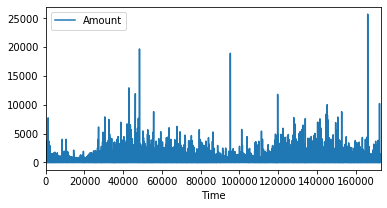

In [13]:
df_original.plot.line(x='Time', y='Amount', figsize=(6, 3))

# Pre-process the data

In [60]:
df = df_original.copy()

### normalize the data
PCA components were supposed to be normalized already. I normalize the 'Amount' and 'Time' variables here

In [15]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(columns=['Amount', 'Time'], inplace=True)
df.rename(columns={'scaled_amount': 'Amount'}, inplace=True)
df.rename(columns={'scaled_time': 'Time'}, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount,Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


### Split into features and labels

In [16]:
def split_to_features_labels(df: pd.DataFrame, non_feature_list: List, label_list: List) -> Tuple[pd.DataFrame, pd.Series]:
    """ Split the data into feature matrix and the labels vector"""
    df_features = df.drop(non_feature_list, axis=1).to_numpy()
    df_label = df[label_list].to_numpy()
    return df_features, df_label

def plot_data(X, y):
    """create a scatter plot of our data and labels"""
    plt.scatter(X[y == 0, 1], X[y == 0, 2], label="Class #0", alpha=0.5, linewidth=0.15)  # Class 0
    plt.scatter(X[y == 1, 1], X[y == 1, 2], label="Class #1", alpha=0.5, linewidth=0.15, c='r')    # Class 1
    plt.legend()
    return plt.show()

def compare_plots(X1, y1, X2, y2):
    """create a scatter plot of our data and labels"""
    figure, axes = plt.subplots(1, 2)
    axes[0].scatter(X1[y1 == 0, 1], X1[y1 == 0, 2], label="Class #0", alpha=0.5, linewidth=0.15)
    axes[0].scatter(X1[y1 == 1, 1], X1[y1 == 1, 2], label="Class #1", alpha=0.3, linewidth=0.15, c='r')
    axes[0].legend
    axes[0].set_title('resampling dataset')

    axes[1].scatter(X2[y2 == 0, 1], X2[y2 == 0, 2], label="Class #0", alpha=0.5, linewidth=0.15)
    axes[1].scatter(X2[y2 == 1, 1], X2[y2 == 1, 2], label="Class #1", alpha=0.3, linewidth=0.15, c='r')
    axes[1].legend
    axes[1].set_title('original dataset')


In [61]:
X, y = split_to_features_labels(df, non_feature_list='Class', label_list='Class')

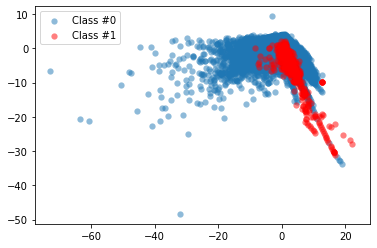

In [18]:
plot_data(X, y)

### Oversampling in Python

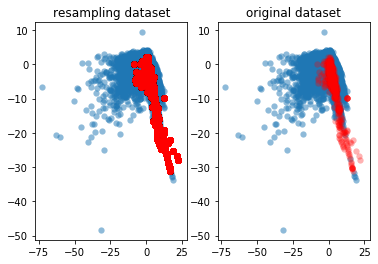

In [19]:
method = RandomOverSampler()
X_resampled, y_resampled = method.fit_sample(X, y)
compare_plots(X_resampled, y_resampled, X, y)

### resampling use SMOTE 

0    284315
1       492
dtype: int64
1    284315
0    284315
dtype: int64


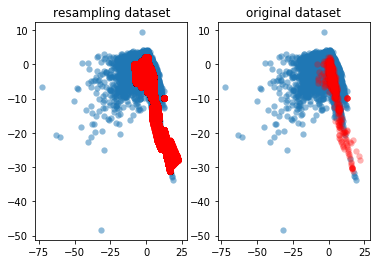

In [20]:
method = SMOTE(kind='regular')
X_resampled, y_resampled = method.fit_sample(X, y)

print(pd.value_counts(pd.Series(y)))
print(pd.value_counts(pd.Series(y_resampled)))

compare_plots(X_resampled, y_resampled, X, y)


In [21]:
# It should by now be clear that our SMOTE has balanced our data completely, and that the minority class is now equal 
# in size to the majority class. Visualizing the data shows the effect on your data very clearly. 

## Using ML classification to catch fraud


### prepare the data

In [22]:
def get_model_results(X_train, y_train, X_test, y_test, model):
    """Train the model and evalute it"""

    model.fit(X_train, y_train)
    predicted = model.predict(X_test)

    accuracy = accuracy_score(y_test, predicted)
    average_precision = average_precision_score(y_test, predicted)
    print('Accuracy ', accuracy)
    print('Average precision score  \n', average_precision)
    print('Classification report \n', classification_report(y_test, predicted))
    print('Confusion matrix \n', confusion_matrix(y_test, predicted))
    return predicted, accuracy, average_precision

In [62]:
X_temp, X_test, y_temp, y_test  = train_test_split(X, y, test_size=0.2, random_state=0)

### (1) Logistic regression

In [63]:
param_dist = {'class_weight': ['balanced', None],
             'penalty': ['l2'],
             'solver': ['liblinear'],
             'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
scorer = make_scorer(f1_score)

model_logistic = GridSearchCV(estimator=LogisticRegression(), 
                        scoring = scorer,
                        param_grid = param_dist,
                        cv=5)

model_logistic.fit(X_temp, y_temp)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), verbose=0)

### model evaluation

In [64]:
mean_test_score = model_logistic.cv_results_['mean_test_score']
print(mean_test_score)
print(model_logistic.best_score_)    # Depend on the scoring in the GridSearchCV
print(model_logistic.best_estimator_)
print(model_logistic.best_params_)
print(model_logistic.score(X_temp, y_temp))    # Depend on the scoring in the GridSearchCV

[0.11422269 0.57823546 0.11563387 0.65714592 0.11462888 0.68570368
 0.11471156 0.68299831 0.11443169 0.67955688 0.11446862 0.67955688
 0.11437335 0.68054971]
0.6857036837600637
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.651872399445215


In [69]:
probs = model_logistic.predict_proba(X_test)
probs

#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
print('ROC AUC is', roc_auc_score(y_test, probs[:,1])) 

plot_precision_recall_curve(y_test, predicted, average_precision_score(y_test, predicted))

ROC AUC is 0.9017071507189409
precision is [0.00177311 0.74025974 1.        ]
recall is [1.         0.56435644 0.        ]


NameError: name 'signature' is not defined

### prediction

In [66]:
predicted = model_logistic.best_estimator_.predict(X_test)
print('score is', model_logistic.score(X_test, y_test))
print('accuracy is', accuracy_score(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))

score is 0.6404494382022472
accuracy is 0.9988764439450862
[[56841    20]
 [   44    57]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.74      0.56      0.64       101

    accuracy                           1.00     56962
   macro avg       0.87      0.78      0.82     56962
weighted avg       1.00      1.00      1.00     56962



### Logistic regression combined with SMOTE


In [27]:
# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE(kind='borderline2')

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model_logistic)])

In [28]:
get_model_results(X_temp, y_temp, X_test, y_test, pipeline)

c:\program files\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy  0.9830764369228608
Average precision score  
 0.07863498052343769
Classification report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.09      0.90      0.16       101

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962

Confusion matrix 
 [[55907   954]
 [   10    91]]


(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 0.9830764369228608,
 0.07863498052343769)

In [29]:
#  the SMOTE improves recall, but the precision is very low
# Remember, not in all cases does resampling necessarily lead to better results. When the fraud cases are 
# very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't
# necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly. 

### Natural hit rate

to understand what the "natural accuracy" is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" you need to "beat" in order to get a better prediction than by doing nothing. In the following exercises, you'll create our first random forest classifier for fraud detection. That will serve as the "baseline" model that you're going to try to improve in the upcoming exercises.


In [47]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

99.82725143693798


In [32]:
#  This tells us that by doing nothing, we would be correct in 99.8% of the cases. So now you understand, 
#that if we get an accuracy of less than this number, our model does not actually add any value in predicting 
#how many cases are correct. Let's see how a random forest does in predicting fraud in our data.

### (2) Random Forest Classifier

In [72]:
scorer = make_scorer(f1_score)

param_grid = {'class_weight': [None, 'balanced_subsample', {0:1, 1:500} ], 
              'max_features': ['sqrt'],  
              'max_depth': [2, 4, 6, 8], 
              'criterion': ['entropy'], 
              'min_samples_leaf': [2, 4, 8, 16],
              'n_estimators':[50]}


rfc = RandomForestClassifier(random_state=0, n_jobs=-1)

model_rfc = GridSearchCV(estimator=rfc, 
                        scoring = scorer,
                        param_grid = param_grid,
                        cv=5)


model_rfc.fit(X_temp, y_temp)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=Fals...om_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'class_w

### evaluate the model

In [73]:
mean_test_score = model_rfc.cv_results_['mean_test_score']
print('mean_test_score = ', mean_test_score, '\n')
print('best_score = ', model_rfc.best_score_, '\n')
print('best_params = ',model_rfc.best_params_, '\n')
# print('params', model_rfc.cv_results_['params'], '\n')


# score of the model, can compare to other model
print('score of the model', model_rfc.score(X_temp, y_temp))


mean_test_score =  [0.65691265 0.65691265 0.65691265 0.65289437 0.80971183 0.81096647
 0.80746522 0.80347015 0.837638   0.83380738 0.83375466 0.82570835
 0.84819303 0.83777766 0.82997362 0.82569235 0.43182399 0.43182399
 0.43182399 0.43182399 0.66011234 0.65520986 0.65293688 0.6614422
 0.74592336 0.74405638 0.74671212 0.72931563 0.82677902 0.82798919
 0.8036036  0.80219311 0.52945928 0.52945928 0.52945928 0.52945928
 0.70056045 0.69737222 0.70305686 0.70145771 0.76221942 0.76829137
 0.74433507 0.73485403 0.83010303 0.83890964 0.81576933 0.80125275] 

best_score =  0.8481930301553531 

best_params =  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50} 

score of the model 0.8953974895397488


### Predict


In [74]:
print('best_estimator_ = ', model_rfc.best_estimator_, '\n')
print(model_rfc.best_estimator_.get_params(), '\n')


predicted = model_rfc.best_estimator_.predict(X_test)
print(confusion_matrix(y_true=y_test, y_pred=predicted))
print(classification_report(y_true=y_test, y_pred=predicted))
print(accuracy_score(y_test, predicted))

best_estimator_ =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False) 

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False} 

[[56855     6]
 [   22    79]]
              precision    recall  f1-score   support

           0       1.00      1

In [67]:
def plot_precision_recall_curve(y_test: pd.DataFrame, predicted: pd.DataFrame, average_precision: float):
    """Plot the recall precision tradeoff"""
    # plot_pr_curve(recall, precision, average_precision)
    
    precision, recall, _ = precision_recall_curve(y_test, predicted)
    print('precision is', precision)
    print('recall is', recall)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))


In [38]:
probs = model_rfc.predict_proba(X_test)
probs

#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
print('ROC AUC is', roc_auc_score(y_test, probs[:,1])) 

plot_precision_recall_curve(y_test, predicted, average_precision_score(y_test, predicted))

ROC AUC is 0.9768251952259471
precision is [0.00177311 0.92857143 1.        ]
recall is [1.         0.77227723 0.        ]


NameError: name 'signature' is not defined

## Voting Classifier


In [ ]:
# Define the three classifiers to use in the ensemble

clf1 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


clf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False) 


# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='hard')

# Get the results 
get_model_results(X_temp, y_temp, X_test, y_test, ensemble_model)


In [ ]:
# You see that by combining the classifiers, you can take the best of multiple models. Compared to pure random forest, You've increased the cases 
# of fraud you are catching from 121 to 122, and you only have 3 extra false positives in return. If you do care about catching
# as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic
# Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false 
# negatives. By combining these together you indeed managed to improve performance.

## Adjust weights within the Voting Classifier


In [ ]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='soft', 
                                  weights=[1, 4], flatten_transform=True)

# Get results 
get_model_results(X_temp, y_temp, X_test, y_test, ensemble_model)